# Practice with Pytorch: we be torching!

Pytorch is a powerful machine learning algorithm and we'll get used to using it to calculate derivatives and to create sequential neural nets etc.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import math

## Example Gradient Calculations

### Simple Equation with Parameter Gradient Calculation

Lets say that y = mx+b. The gradient dy/dx is of course m. Lets show this using Pytorch's gradient calculator.

In [2]:
mslope = torch.tensor(3.0, requires_grad = True) #this requires grad statement is needed as pytorch doesn't track all the gradients by default
xval = torch.tensor(4.5, requires_grad = True)
bint = torch.tensor(1.23, requires_grad = True)

In [3]:
yval = mslope*xval + bint

In [4]:
yval.backward() #calculate the gradients (complete backward propagation)

In [5]:
xval.grad, mslope.grad, bint.grad #gradients with respect to yval (what backward was performed on)

(tensor(3.), tensor(4.5000), tensor(1.))

### Heat transfer from a constant temperature pipe wall

A pipe (with fouling) is held at a constant temperature of 50 C with water flowing inside a 1-inch diamter pipe at a velocity of 2 m/s. Inlet temperature of the water is 20 C and the length of the pipe is 10m. What is the outlet temperature?

First calculate fluid properties of water vs. temperature (T) in K (kg/m3, Pa$\cdot$s, W/mK, J/kgK):
\begin{align}
\rho &= 0.322 + 1.055T^{0.35} - 1.717 T^{0.667} + 3.850 T - 2.543T^{1.333}\\
\mu &= exp(-52.84 + 3704/T+5.87ln(T)) \\
k &= -0.432 + 0.00573T - 8.08e^{-6}T^2 + 1.86e^{-9}T^3\\
C_p &= (276.4 - 2.09T + 8.13e^{-3}T^2 - 1.41e^{-5}T^3 + 9.37e^{-9}T^4)/Mw
\end{align}

Then calculate the Reynolds and Prandtl numbers
\begin{align}
Re &= \rho Dv/\mu \\
Pr &= C_p \mu/k
\end{align}

Now calculate the Nusselt number and heat transfer coeefficient from the internal pipe flow correlation for the given Re
\begin{align}
Nu &= 0.023Re^{0.8}Pr^{0.333}\\
h &= Nu\cdot k/D
\end{align}

Now calculate the outlet temperature from Newton's law of cooling

\begin{align}
q &= UA(T_{p} - T_f) = \dot m C_p(T_{out} - T_{in}) \\
A &= \pi D L \\
U &= \frac{1}{1/h + R_f}
\end{align}

Lets say $T_f$, temperature of the fluid, is $(T_{out} + T_{in})/2$, thus

\begin{align}
UA[T_p - (T_{out} + T_{in})/2] &= \dot m C_p(T_{out} - T_{in}) \\
UA(2T_p - T_{out} - T_{in}) &= 2\dot m C_p(T_{out} - T_{in}) \\
T_{out}(-1 - \frac{2\dot m C_p}{UA}) &= T_{in}-2T_p-\frac{2\dot m C_p}{UA}T_{in} \\
T_{out} &= \left[ T_{in}-2T_p-\frac{2\dot m C_p}{UA}T_{in} \right] / \left[ (-1 - \frac{2\dot m C_p}{UA}) \right]
\end{align}

In [6]:
def Tout(Tin=300., Tpipe=350., Dia=0.03, Velocity=2., Length=10., Rfoul=1.5e-5):
    #inputs
    Ti = torch.tensor(Tin, requires_grad = True)
    Tp = torch.tensor(Tpipe, requires_grad = True) #pipe temperature
    D = torch.tensor(Dia, requires_grad = True) #
    vel = torch.tensor(Velocity, requires_grad = True) # m/s
    L = torch.tensor(Length, requires_grad = True) #m, length of pipe
    Rf = torch.tensor(Rfoul, requires_grad = True)
    Nu_a = torch.tensor(0.023, requires_grad = True) #Nusselt number multiplier
    Nu_b = torch.tensor(0.8, requires_grad = True) #Nusselt Re number exponent
    Nu_c = torch.tensor(0.33, requires_grad = True) #Nusselt Pr number exponent

    #Properties (density, viscosity, thermal conductivity, and heat capacity)
    Tf = (Ti+Tp)/2 #Estimate for fluid properties
    tau = Tf/647. #647 is the critical temperature of water
    den = (17.863 + 58.606*tau**0.35 - 95.396*tau**0.66667 + 213.89*tau - 141.25*tau**1.33333)*18 #density kg/m3
    #den2 =
    visc = 2.71828183**(-52.84 + 3704./Tf + 5.87*math.log(Tf)) # viscosity Pa*s, dippr
    visc2 = 2.414e-5 * 10**(247.8/(Tf-140.)) #Engineering data?
    kt = -0.432 + 0.00573*Tf - 8.08e-6*Tf**2 + 1.86e-9*Tf**3 # thermal conductivity W/m/K
    Cph = (276.4 - 2.09*Tf + 8.13e-3*Tf**2 - 1.41e-5*Tf**3 + 9.37e-9*Tf**4)/0.018 # heat capacity J/kg/K

    #Retain gradients to include in the evaluation of which gradients are the largest
    kt.retain_grad()
    visc.retain_grad()
    visc2.retain_grad()
    Cph.retain_grad()
    den.retain_grad()
    Ti.retain_grad()
    Tp.retain_grad()
    Rf.retain_grad()

    #area and mass flow rate
    A = math.pi*L*D; #m^2 area of internal pipe
    md = math.pi*D**2/4*vel*den #kg/s

    #Dimensionless numbers
    Re = den*D*vel/visc; Re.retain_grad() #Reynolds number
    Pr = Cph*visc/kt; Pr.retain_grad() #Prandtl number

    #Nusselt and convective heat transfer coefficient
    Nu = torch.where(Re<2300,3.66,Nu_a*Re**Nu_b*Pr**Nu_c)
    hi = Nu*kt/D

    # Overall heat transfer coefficient
    U = 1/(1/hi + Rf)

    #Tout
    To_calc = (2*Tp + 2*md*Cph/(U*A)*Ti - Ti)/(1+2*md*Cph/(U*A))
    To = torch.minimum(To_calc, Tp); To.retain_grad()
    To.backward()


    return den, visc, kt, Cph, D, vel, L, Ti, Tp, Rf, Re, Pr, To, Nu_a, Nu_b, Nu_c

In [7]:
den, visc, kt, Cph, D, vel, L, Ti, Tp, Rf, Re, Pr, To, Nu_a, Nu_b, Nu_c = Tout()

/tmp/ipython-input-101927587.py:18: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  visc = 2.71828183**(-52.84 + 3704./Tf + 5.87*math.log(Tf)) # viscosity Pa*s, dippr


In [8]:
params = {
    "Density (de)": den,
    "Viscosity (vi)": visc,
    "Conductivity (k)": kt,
    "Specific Heat (Cp)": Cph,
    "Diameter (D)": D,
    "Velocity (vel)": vel,
    "Length (L)": L,
    "Inlet Temp (Ti)": Ti,
    "Pipe Temp (Tp)": Tp,
    "Fouling (Rf)": Rf,
    "Re": Re,
    "Pr": Pr,
    "Outlet Temp (To)":To,
    "Nu_a": Nu_a,
    "Nu_b": Nu_b,
    "Nu_c": Nu_c
}

# Calculate Normalized Sensitivity (grad * data)
# We use .item() to extract the standard float value from the 0-d tensor
sensitivities = {}
for name, tensor in params.items():
    if tensor.grad is not None:
        # Sensitivity = d(Output)/d(Param) * Param
        sensitivities[name] = tensor.grad.item() * tensor.item()

# We want to see the biggest drivers regardless of direction (+/-)
sorted_sensitivities = dict(sorted(
    sensitivities.items(),
    key=lambda item: abs(item[1]),
    reverse=True
))

print(f"{'Parameter':<20} | {'Value (val)':<8} | {'Sensitivity (grad*val)':<25}")
print("-" * 67)
for name, val in sorted_sensitivities.items():
    print(f"{name:<20} | {params[name].item():.2e}    | {val:.4f}")

Parameter            | Value (val) | Sensitivity (grad*val)   
-------------------------------------------------------------------
Outlet Temp (To)     | 3.36e+02    | 336.0866
Pipe Temp (Tp)       | 3.50e+02    | 315.0779
Nu_b                 | 8.00e-01    | 190.8333
Inlet Temp (Ti)      | 3.00e+02    | 137.0279
Diameter (D)         | 3.00e-02    | -27.1875
Length (L)           | 1.00e+01    | 23.0642
Nu_a                 | 2.30e-02    | 20.6165
Re                   | 1.06e+05    | 16.4932
Specific Heat (Cp)   | 4.24e+03    | -16.2608
Conductivity (k)     | 6.41e-01    | 13.8131
Viscosity (vi)       | 5.58e-04    | -9.6898
Nu_c                 | 3.30e-01    | 8.8888
Pr                   | 3.69e+00    | 6.8034
Velocity (vel)       | 2.00e+00    | -6.5710
Density (de)         | 9.84e+02    | -6.5710
Fouling (Rf)         | 1.50e-05    | -2.4477


In [9]:
!pip install torchviz

In [10]:
from torchviz import make_dot
dot = make_dot(To, params=params)

# This saves a file named "computational_graph.pdf" in your folder
dot.render("computational_graph2", format="png", view=True)

'computational_graph2.png'

## Setup a simple Neural Net and Train It

In [83]:
#Simple nueral net with an input and output layer (and activation between)
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
                nn.Linear(1, 12), # Increased width slightly for better capacity
                nn.ReLU(),        # ReLU often trains faster than Tanh for regression
                nn.Linear(12, 1))

    def forward(self, x):
        return self.fc(x)

model = MLP()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.035)

In [84]:
# Data
xin = torch.tensor([[3.0],[2.0],[4.5],[6.5]], dtype=torch.float32)
ygt = torch.tensor([[34.1],[56.9],[12.4],[-9.7]], dtype=torch.float32)

# Simple Normalization for ygt (optional but highly recommended)
target_mean = ygt.mean()
target_std = ygt.std()
ygt_norm = (ygt - target_mean) / target_std

In [85]:
# Initial Check
print("\nInitial Predictions vs Ground Truth:")
final_pred = (model(xin) * target_std) + target_mean
for p, g in zip(final_pred, ygt):
    print(f"Pred: {p.item():.2f} | GT: {g.item():.2f}")
print("\n")

#Train the Weights
epochs = 10000
for epoch in range(epochs):
    ypred = model(xin)
    loss = criterion(ypred, ygt_norm) # Train on normalized data

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        # To see the actual prediction, un-normalize it
        actual_pred = (ypred * target_std) + target_mean
        print(f'Epoch {epoch+1} | Loss: {loss.item():.6f}')

# Final Check
print("\nFinal Predictions vs Ground Truth:")
final_pred = (model(xin) * target_std) + target_mean
for p, g in zip(final_pred, ygt):
    print(f"Pred: {p.item():.2f} | GT: {g.item():.2f}")


Initial Predictions vs Ground Truth:
Pred: 25.73 | GT: 34.10
Pred: 23.80 | GT: 56.90
Pred: 30.64 | GT: 12.40
Pred: 37.19 | GT: -9.70


Epoch 1000 | Loss: 0.017919
Epoch 2000 | Loss: 0.017919
Epoch 3000 | Loss: 0.000000
Epoch 4000 | Loss: 0.000002
Epoch 5000 | Loss: 0.000000
Epoch 6000 | Loss: 0.000000
Epoch 7000 | Loss: 0.000000
Epoch 8000 | Loss: 0.000906
Epoch 9000 | Loss: 0.000010
Epoch 10000 | Loss: 0.000001

Final Predictions vs Ground Truth:
Pred: 34.06 | GT: 34.10
Pred: 56.87 | GT: 56.90
Pred: 12.37 | GT: 12.40
Pred: -9.74 | GT: -9.70


In [86]:
# Lets inspect the sensitivity of the weights (like we did for the above heat transfer problem)
# the sensitivity is the product of the weight value and it's gradient
print("Sensitivities of model weights (parameters)")
for name, param in model.named_parameters():
    if param.grad is not None:
      print(f"\nParameter: {name}")
      print(f"Shape: {param.grad.shape}")
      #print(f"Gradient Snippet:\n{param.grad[:, :]if param.grad.dim() > 1 else param.grad}")
      #print(f"Weight Snippet:\n{param[:, :]if param.grad.dim() > 1 else param}")
      print(f"Sensitivity Snippet:\n{param.grad[:, :]*param if param.grad.dim() > 1 else param.grad*param}")
      print("-" * 60)
    else:
      print(f"\nParameter: {name} has no gradient (requires_grad=False)")

Sensitivities of model weights (parameters)

Parameter: fc.0.weight
Shape: torch.Size([12, 1])
Sensitivity Snippet:
tensor([[-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.0000],
        [-0.0009],
        [-0.0000],
        [-0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0030]], grad_fn=<MulBackward0>)
------------------------------------------------------------

Parameter: fc.0.bias
Shape: torch.Size([12])
Sensitivity Snippet:
tensor([0.0000, 0.0000, 0.0000, -0.0000, -0.0000, 0.0000, 0.0013, -0.0000, -0.0000,
        -0.0000, -0.0000, 0.0012], grad_fn=<MulBackward0>)
------------------------------------------------------------

Parameter: fc.2.weight
Shape: torch.Size([1, 12])
Sensitivity Snippet:
tensor([[ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0003,  0.0000,
         -0.0000, -0.0000,  0.0000, -0.0018]], grad_fn=<MulBackward0>)
------------------------------------------------------------

Parameter: fc

You can see that, after training, the sensitivities of some of the weights (or biases) are zero. Those particular parameters (at their current values) have no more effect on the outcome with a small change.

## Another example fit of non-linear line regression

In [87]:
# 1. Data Generation (keeping your original logic)
x_np = np.linspace(0, 10, 100).reshape(-1, 1)
y_np = -2.5 * x_np + 3 + np.random.normal(1, 2, size=x_np.shape)
y_np += 3 * (np.log((x_np - 4)**2 + 1e-6)) # added small epsilon to avoid log(0)

# Convert to PyTorch Tensors
X = torch.tensor(x_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32)

# 2. Define the NN Architecture
class NNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = NNRegressor()

# 3. Setup Loss and Optimizer (Adam)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# 4. Training Loop
epochs = 5000 # PyTorch often converges faster with higher LR than scikit-learn's default
for epoch in range(epochs):
    # Forward pass
    predictions = model(X)
    loss = criterion(predictions, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 5. Final Prediction and Loss
model.eval()
with torch.no_grad():
    y_mlp_pred = model(X)
    mlp_loss = criterion(y_mlp_pred, y).item()

print(f"\nFinal MSE Loss: {mlp_loss:.4f}")

Epoch [500/5000], Loss: 10.8898
Epoch [1000/5000], Loss: 8.9716
Epoch [1500/5000], Loss: 8.2681
Epoch [2000/5000], Loss: 6.9756
Epoch [2500/5000], Loss: 6.4220
Epoch [3000/5000], Loss: 6.1459
Epoch [3500/5000], Loss: 5.9374
Epoch [4000/5000], Loss: 5.6248
Epoch [4500/5000], Loss: 5.4607
Epoch [5000/5000], Loss: 5.3746

Final MSE Loss: 5.3742


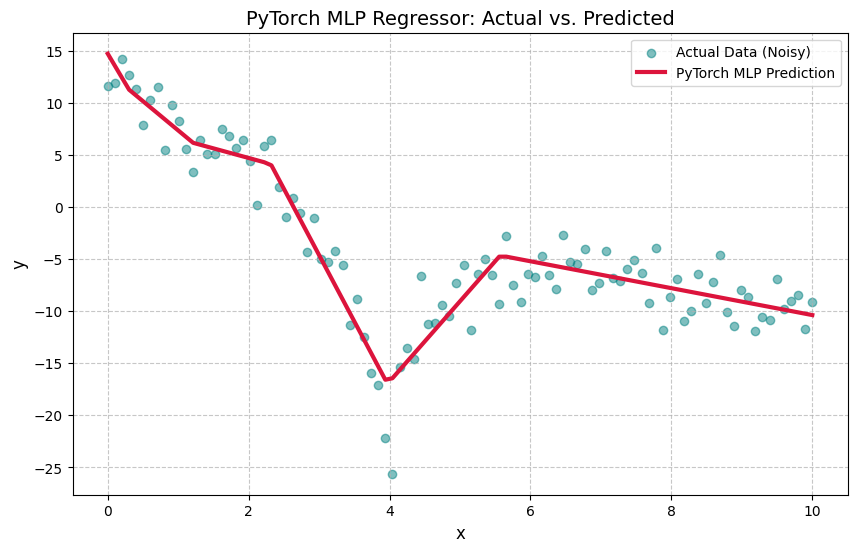

In [88]:
# 1. Get predictions (ensure we are in evaluation mode)
model.eval()
with torch.no_grad():
    y_pred_np = model(X).numpy()

# 2. Plotting
plt.figure(figsize=(10, 6))

# Plot the noisy original data
plt.scatter(x_np, y_np, color='teal', alpha=0.5, label='Actual Data (Noisy)')

# Plot the MLP's prediction line
plt.plot(x_np, y_pred_np, color='crimson', linewidth=3, label='PyTorch MLP Prediction')

# Formatting
plt.title('PyTorch MLP Regressor: Actual vs. Predicted', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [89]:
#get a prediction for a single value of x
xval = 4.2
input_tensor = torch.tensor([[xval]], dtype=torch.float32)
with torch.no_grad():
    prediction = model(input_tensor)
result = prediction.item()
print(f"For x = {xval}, the predicted y is: {result:.4f}")

For x = 4.2, the predicted y is: -15.2122


In [90]:
# View the keys and the shapes of the weight tensors
for name, param in model.state_dict().items():
    print(f"Layer: {name} | Size: {param.size()}")
    print(param) # This prints the actual numerical tensor
    print("-" * 60)

Layer: layers.0.weight | Size: torch.Size([15, 1])
tensor([[ 0.0178],
        [-1.9198],
        [ 3.3781],
        [-0.2284],
        [-1.1096],
        [-0.8317],
        [ 2.0156],
        [-0.6746],
        [-0.9713],
        [-0.4958],
        [ 1.7100],
        [-1.1105],
        [-1.1185],
        [-0.9440],
        [ 2.5100]])
------------------------------------------------------------
Layer: layers.0.bias | Size: torch.Size([15])
tensor([-9.8765e-01,  1.0694e+01, -7.8090e+00, -2.9368e-03,  4.3863e+00,
        -6.7311e-01, -4.6723e+00, -9.6753e-01, -7.7647e-01, -5.8214e-01,
        -2.0722e+00,  4.4414e+00,  4.4648e+00,  3.7354e+00, -7.5461e-01])
------------------------------------------------------------
Layer: layers.2.weight | Size: torch.Size([1, 15])
tensor([[-0.1478, -4.6824, -2.4241,  0.0170,  7.3514, -0.2171, -1.3358, -0.0722,
         -0.0202,  0.1745,  2.1993,  3.4920,  3.6836,  4.5250,  2.3227]])
------------------------------------------------------------
Layer: l

## Torch can be used as an optimizer
to minimize a loss function by changing variables as shown below.

In [42]:
# --- 1. SETUP CONSTANTS & FUNCTIONS ---
# We treat these as fixed "environment" variables for the optimization
Ti = 300.
Tp = 350.
Target_To = 305. # We want the outlet to be exactly this value, K
L = 10.
Rf = 1.5e-5

# --- 2. DEFINE THE "WEIGHT" (The Learnable Parameter) ---
# We start with a guess of 2.0 m/s.
# We want PyTorch to change this value to hit the target Temp.
vel = torch.tensor(2.0, requires_grad=True)
D = torch.tensor(1 * 0.0254 * 1.2, requires_grad=True)

# --- 3. THE OPTIMIZER ---
# This replaces the manual update (vel = vel - lr * grad).
# Adam is a standard optimizer used in Deep Learning.
optimizer = torch.optim.Adam([vel,D], lr=0.02)

print(f"{'Iter':<5} | {'Velocity (m/s)':<15} | {'Diameter (m)':<15} | {'Outlet T (K)':<15} | {'Loss':<15}")
print("-" * 55)

# --- 4. THE TRAINING LOOP ---
for i in range(1001):

    # A. Reset Gradients (Don't let them accumulate from previous loop)
    optimizer.zero_grad()

    # B. Forward Pass (The Physics Model)
    # Note: Physics calculations are inside the loop because they depend on 'vel'
    # -------------------------------------------------------------------------
    # Update properties based on current estimated Avg Temp (simplified)
    # Realistically, you'd iterate T_avg, but for demo we use fixed property T
    Temp = torch.tensor(325.)

    # Property Correlations (Fixed Units & Unified Viscosity)
    Cph_mol = 276.4 - 2.09*Temp + 8.13e-3*Temp**2 - 1.41e-5*Temp**3 + 9.37e-9*Temp**4
    Cp = Cph_mol / 0.018 # FIXED: Converted to J/kg*K

    visc = 2.71828183**(-52.84 + 3704./Temp + 5.87*math.log(Temp)) # Unified Viscosity
    kt = -0.432 + 0.00573*Temp - 8.08e-6*Temp**2 + 1.86e-9*Temp**3

    tau = Temp/647.
    den = (17.863 + 58.606*tau**0.35 - 95.396*tau**0.66667 + 213.89*tau - 141.25*tau**1.33333)*18

    # Dimensionless Numbers & Heat Transfer
    A = math.pi*L*D
    md = math.pi*D**2/4 * vel * den # Depends on 'vel'

    Re = den*D*vel/visc             # Depends on 'vel'
    Pr = Cp*visc/kt

    Nu = 0.023 * Re**0.8 * Pr**0.33
    hi = Nu * kt / D
    U = 1/(1/hi + Rf)

    # Calculate Outlet Temp
    To = (Ti - 2*Tp - 2*md*Cp/(U*A)*Ti)/(-1-2*md*Cp/(U*A))

    # C. Calculate Loss (The Error)
    loss = (To - Target_To)**2

    # D. Backward Pass (Calculate Gradients)
    loss.backward()

    # E. Optimizer Step (Update 'vel')
    optimizer.step()

    # Print progress every 20 steps
    if i % 50 == 0:
        print(f"{i:<5} | {vel.item():.4f}          | {D.item():.4f}          | {To.item():.4f}          | {loss.item():.2e}")

print("-" * 55)
print(f"FINAL RESULT: To get T_out = {Target_To} K, Velocity must be {vel.item():.4f} m/s")

Iter  | Velocity (m/s)  | Diameter (m)    | Outlet T (K)    | Loss           
-------------------------------------------------------
0     | 2.0200          | 0.0505          | 335.6561          | 9.40e+02
50    | 2.2436          | 0.2096          | 305.2211          | 4.89e-02
100   | 2.2541          | 0.2126          | 305.1299          | 1.69e-02
150   | 2.2608          | 0.2138          | 305.0913          | 8.34e-03
200   | 2.2663          | 0.2149          | 305.0604          | 3.64e-03
250   | 2.2703          | 0.2157          | 305.0377          | 1.42e-03
300   | 2.2731          | 0.2162          | 305.0222          | 4.92e-04
350   | 2.2749          | 0.2165          | 305.0124          | 1.54e-04
400   | 2.2759          | 0.2167          | 305.0065          | 4.27e-05
450   | 2.2765          | 0.2168          | 305.0033          | 1.07e-05
500   | 2.2768          | 0.2169          | 305.0015          | 2.33e-06
550   | 2.2770          | 0.2169          | 305.0007          |

## Torch as a Fitting Tool

Similarly to above, torch can be used to find optimum values for fitting data to a relationship with the relationship somewhat complex

Step  | a          | b          | c          | Loss (MSE)     
------------------------------------------------------------
0     | 0.97500    | 0.47500    | 0.47500    | 80992.66
500   | 0.60106    | 0.50863    | 0.31234    | 949.68
1000  | 0.08728    | 0.68209    | 0.31679    | 245.37
1500  | 0.04716    | 0.73771    | 0.31439    | 157.56
2000  | 0.08774    | 0.68207    | 0.31371    | 245.50
2500  | 0.07907    | 0.69144    | 0.31358    | 226.51
3000  | 0.03724    | 0.75906    | 0.31349    | 139.19
3500  | 0.12056    | 0.65366    | 0.31190    | 314.14
4000  | 0.06930    | 0.70329    | 0.31364    | 205.01
4500  | 0.05578    | 0.72277    | 0.31363    | 175.44
5000  | 0.04405    | 0.74399    | 0.31358    | 151.36
------------------------------------------------------------
TRUE VALUES: a=0.023, b=0.8, c=0.33
LEARNED:     a=0.04405, b=0.74399, c=0.31358


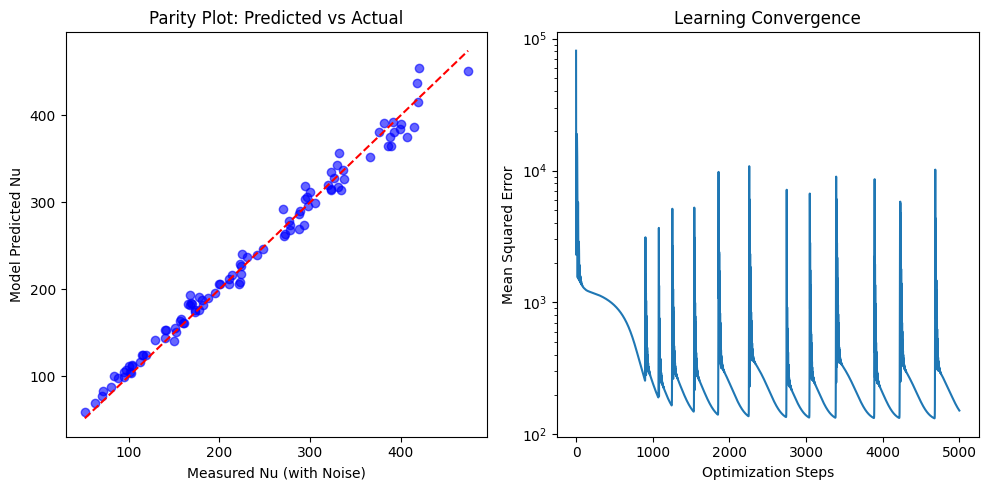

In [ ]:
# --- 1. GENERATE "FAKE" LAB DATA ---
# We create 100 data points with random Re and Pr values
n_samples = 100
torch.manual_seed(42) # For reproducibility

# Random Reynolds (10,000 to 100,000) and Prandtl (0.7 to 10)
Re_data = torch.rand(n_samples) * 90000 + 10000
Pr_data = torch.rand(n_samples) * 9.3 + 0.7

# The "True" Physics (Dittus-Boelter)
# Nu = 0.023 * Re^0.8 * Pr^0.33
true_a, true_b, true_c = 0.023, 0.8, 0.33
Nu_clean = true_a * (Re_data**true_b) * (Pr_data**true_c)

# Add 5% random Gaussian noise to simulate sensor error
noise = torch.randn(n_samples) * 0.05 * Nu_clean
Nu_measured = Nu_clean + noise

# --- 2. DEFINE THE MODEL (The "Guessed" Equation) ---
# We initialize with WRONG values.
# a=1.0, b=0.5, c=0.5 (Instead of 0.023, 0.8, 0.33)
a = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)
c = torch.tensor(0.5, requires_grad=True)

# --- 3. THE OPTIMIZER ---
# We use Adam because it handles the different scales of gradients well
# (Sensitivity of 'a' is very different from sensitivity of exponent 'b')
optimizer = torch.optim.Adam([a, b, c], lr=0.025)

print(f"{'Step':<5} | {'a':<10} | {'b':<10} | {'c':<10} | {'Loss (MSE)':<15}")
print("-" * 60)

# --- 4. THE LEARNING LOOP ---
loss_history = []

for step in range(5001):

    optimizer.zero_grad()

    # The Model Prediction
    Nu_pred = a * (Re_data**b) * (Pr_data**c)

    # The Loss Function (Mean Squared Error)
    # We compare our prediction to the NOISY measured data
    loss = torch.mean((Nu_pred - Nu_measured)**2)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if step % 500 == 0:
        print(f"{step:<5} | {a.item():.5f}    | {b.item():.5f}    | {c.item():.5f}    | {loss.item():.2f}")

print("-" * 60)
print(f"TRUE VALUES: a=0.023, b=0.8, c=0.33")
print(f"LEARNED:     a={a.item():.5f}, b={b.item():.5f}, c={c.item():.5f}")

# --- 5. VISUALIZATION ---
# Plot Predicted vs Measured (Parity Plot)
with torch.no_grad():
    Nu_final_pred = a * (Re_data**b) * (Pr_data**c)

plt.figure(figsize=(10, 5))

# Subplot 1: Parity Plot
plt.subplot(1, 2, 1)
plt.scatter(Nu_measured.numpy(), Nu_final_pred.numpy(), alpha=0.6, color='blue')
plt.plot([Nu_measured.min(), Nu_measured.max()], [Nu_measured.min(), Nu_measured.max()], 'r--')
plt.xlabel("Measured Nu (with Noise)")
plt.ylabel("Model Predicted Nu")
plt.title("Parity Plot: Predicted vs Actual")

# Subplot 2: Loss Curve
plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel("Optimization Steps")
plt.ylabel("Mean Squared Error")
plt.title("Learning Convergence")

plt.tight_layout()
plt.show()

In [28]:
import numpy as np